# Lab 3: Classifying Surnames with a CNN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/DSML4220/blob/main/lab3_cnn_for_surnames.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/DSML4220/blob/main/lab3_cnn_for_surnames.ipynb)

We previously looked at a multi-layer perceptron to solve the multiclass classification problem of trying to predict the nationality/language of a lastname. We'll now see how a CNN performs for this task. Again, recall that: 
* there are 18 class labels the model must distinguish between and make predictions for
* the input is a single last name, which meant that we tokenized by characters (rather than by words or partial words)

Note that the code and data in this notebook is derived from notebook [found here](https://github.com/delip/PyTorchNLPBook/blob/master/chapters/chapter_4/4_4_cnn_surnames/4_4_Classifying_Surnames_with_a_CNN.ipynb), which comes from the repository, [PyTorchNLPBook, found here](https://github.com/delip/PyTorchNLPBook).


### Lab 3 Assignment/Task 
Answer the four (4) questions in the notebook here. Most of them require changing something about the model and re-running it, so it may take a little bit of time to complete this notebook (and best to use a GPU if you can). 


## Imports

In [1]:
from argparse import Namespace
import json
import os
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Vectorize Data

In [77]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [78]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab, max_surname_length):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
            max_surname_length (int): the length of the longest surname
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
        self._max_surname_length = max_surname_length

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot_matrix (np.ndarray): a matrix of one-hot vectors
        """

        one_hot_matrix_size = (len(self.surname_vocab), self._max_surname_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
                               
        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index] = 1
        
        return one_hot_matrix

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        max_surname_length = 0

        for index, row in surname_df.iterrows():
            max_surname_length = max(max_surname_length, len(row.surname))
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab, max_surname_length)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab, 
                   max_surname_length=contents['max_surname_length'])

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable(), 
                'max_surname_length': self._max_surname_length}

In [79]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            name_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameDataset
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        surname_matrix = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_matrix,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### Classifier

In [80]:
class SurnameClassifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes, num_channels):
        """
        Args:
            initial_num_channels (int): size of the incoming feature vector
            num_classes (int): size of the output prediction vector
            num_channels (int): constant channel size to use throughout network
        """
        super(SurnameClassifier, self).__init__()
        
        self.convnet = nn.Sequential(
            #nn.Conv1d(in_channels=initial_num_channels, out_channels=num_channels, kernel_size=2, dilation=2),
            nn.Conv1d(in_channels=initial_num_channels, out_channels=num_channels, kernel_size=3),
            nn.ELU(),

            #nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=2, dilation=2, stride=2),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=2),
            nn.ELU(),

            #nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=2, dilation=2, stride=2),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=2),
            nn.ELU(),

            # replace previous Conv layer with a pooling layer (must ensure size is the same)
            #nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=3),
            nn.AdaptiveMaxPool1d(1),
            nn.ELU()
        )
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x_surname, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        features = self.convnet(x_surname).squeeze(dim=2)
       
        prediction_vector = self.fc(features)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector


### Training

In [81]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

In [82]:
def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [83]:
def compute_accuracy(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [91]:
args = Namespace(
    # Data and Path information
    surname_csv='https://raw.githubusercontent.com/sgeinitz/DSML4220/main/data/surnames.csv',
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="data/surname_cnn",
    # Model hyper parameters
    hidden_dim=100,
    num_channels=256,
    # Training hyper parameters
    seed=50,
    learning_rate=0.0005,
    batch_size=128,
    num_epochs=100, #0,
    early_stopping_criteria=5,
    dropout_p=0.33,
    # Runtime options
    cuda=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    catch_keyboard_interrupt=True
)


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	data/surname_cnn/vectorizer.json
	data/surname_cnn/model.pth
Using CUDA: False


In [92]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(initial_num_channels=len(vectorizer.surname_vocab), 
                               num_classes=len(vectorizer.nationality_vocab),
                               num_channels=args.num_channels)

classifer = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)

#optimizer = optim.SGD(classifier.parameters(), lr=args.learning_rate)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

train_state = make_train_state(args)

In [93]:
import tqdm.auto 

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            losses['train'].append(loss_t)
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            accuracies['train'].append(acc_t)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            losses['val'].append(loss_t)
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            accuracies['val'].append(acc_t)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/60 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

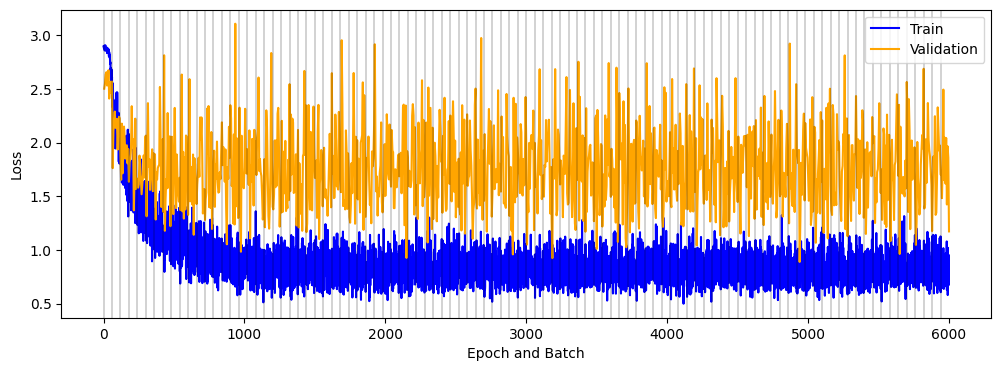

In [94]:
matplotlib.rc('figure', figsize=(12,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue')
plt.plot(val_ticks, losses['val'], c='orange')
for i in range(args.num_epochs):
    plt.axvline(x=i*len(losses['train'])/args.num_epochs, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

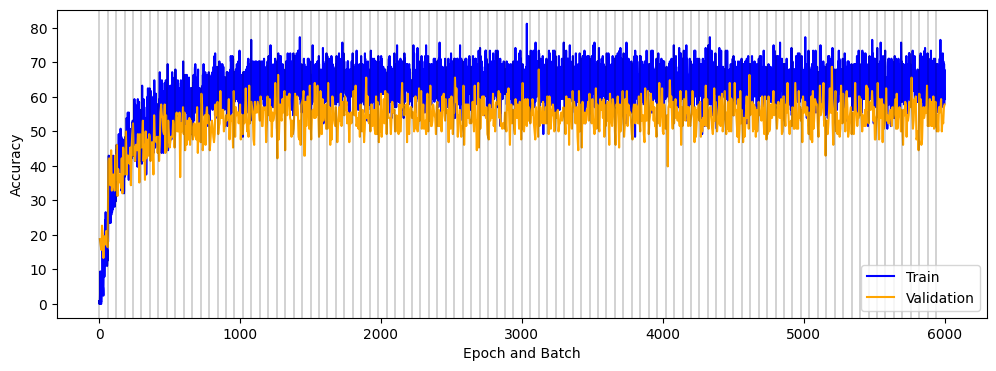

In [95]:
matplotlib.rc('figure', figsize=(12,4))
val_ticks = [(i+1)*len(accuracies['train'])/len(accuracies['val']) for i in range(len(accuracies['val']))]
plt.plot(range(len(accuracies['train'])), accuracies['train'], c='blue')
plt.plot(val_ticks, accuracies['val'], c='orange')
for i in range(args.num_epochs):
    plt.axvline(x=i*len(accuracies['train'])/args.num_epochs, c='black', lw=0.25)
plt.ylabel('Accuracy')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [96]:

classifier.load_state_dict(torch.load(train_state['model_filename'], weights_only=True))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [97]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.6850142578283944;
Test Accuracy: 56.380208333333336


***
### Q1
Try using the vanilla Stochastic Gradient Descent optimizer above. How does the model perform when using this versus the Adam optimizer? What do the loss and accuracy curves look like after training for SGD versus Adam? 

#### Adam Optimizer results

```
Test loss: 1.7799422883987428;
Test Accuracy: 59.875
```

![Adam Optimizer](results/adamacc.png)
![Adam Optimizer](results/adamloss.png)

* Accuracy improving over each epoch for both training and validation sets
* Generally upward trend dispite the volatility

* Loss is decreasing over each epoch for both training however validation becomes volatile after 600 epochs
* Interesting dispite the increase in accuracy the loss is increasing for the validation set

take away : Adam is a good optimizer for this model


#### Vanilla SGD Optimizer results

```
Test loss: 2.8913688755035403;
Test Accuracy: 0.5624999999999999
```

![Vanilla SGD Optimizer](results/sgdacc.png)
![Vanilla SGD Optimizer](results/sgdloss.png)

* Accuracy is extremely volatile regardless of the Epoch -- no consistency or pattern
* Indicates that model is not learning well or at all 

* loss also appears to be volatile regardless of Epoch
* both training and validation loss are high and volatile

take away : SGD is not a good optimizer for this model

***



### Inference

In [98]:
def predict_nationality(surname, classifier, vectorizer):
    """Predict the nationality from a new surname
    
    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely nationality and its probability
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality, 'probability': probability_value}

In [99]:
new_surname = input("Enter a surname to classify: ")
classifier = classifier.cpu()
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

thang -> Chinese (p=0.59)


In [100]:
def predict_topk_nationality(surname, classifier, vectorizer, k=5):
    """Predict the top K nationalities from a new surname
    
    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
        k (int): the number of top nationalities to return
    Returns:
        list of dictionaries, each dictionary is a nationality and a probability
    """
    
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    prediction_vector = classifier(vectorized_surname, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)
    
    # returned size is 1,k
    probability_values = probability_values[0].detach().numpy()
    indices = indices[0].detach().numpy()
    
    results = []
    for kth_index in range(k):
        nationality = vectorizer.nationality_vocab.lookup_index(indices[kth_index])
        probability_value = probability_values[kth_index]
        results.append({'nationality': nationality, 
                        'probability': probability_value})
    return results

new_surname = input("Enter a surname to classify: ")

k = 15 #int(input("How many of the top predictions to see? "))
if k > len(vectorizer.nationality_vocab):
    print("Sorry! That's more than the # of nationalities we have.. defaulting you to max size :)")
    k = len(vectorizer.nationality_vocab)
    
predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['nationality'],
                                        prediction['probability']))

Top 15 predictions:
thang -> Chinese (p=0.59)
thang -> Korean (p=0.24)
thang -> Vietnamese (p=0.16)
thang -> Irish (p=0.00)
thang -> English (p=0.00)
thang -> Arabic (p=0.00)
thang -> German (p=0.00)
thang -> Russian (p=0.00)
thang -> Scottish (p=0.00)
thang -> Czech (p=0.00)
thang -> Dutch (p=0.00)
thang -> Japanese (p=0.00)
thang -> French (p=0.00)
thang -> Polish (p=0.00)
thang -> Italian (p=0.00)


In [101]:
256 * (77*3) + 256

59392

In [102]:
dataset[0]['x_surname'].shape

(77, 17)

In [103]:
#!pip install torchinfo
import torchinfo 
#summ = torchinfo.summary(classifier, (dataset[0]['x_surname'].shape))
#summ = torchinfo.summary(classifier, (torch.tensor(dataset[0]['x_surname']).unsqueeze(dim=0).shape))
# OR 
summ = torchinfo.summary(classifier, (np.expand_dims(dataset[0]['x_surname'], axis=0).shape))

print(summ)

Layer (type:depth-idx)                   Output Shape              Param #
SurnameClassifier                        [1, 18]                   --
├─Sequential: 1-1                        [1, 256, 1]               --
│    └─Conv1d: 2-1                       [1, 256, 15]              59,392
│    └─ELU: 2-2                          [1, 256, 15]              --
│    └─Conv1d: 2-3                       [1, 256, 7]               196,864
│    └─ELU: 2-4                          [1, 256, 7]               --
│    └─Conv1d: 2-5                       [1, 256, 3]               196,864
│    └─ELU: 2-6                          [1, 256, 3]               --
│    └─AdaptiveMaxPool1d: 2-7            [1, 256, 1]               --
│    └─ELU: 2-8                          [1, 256, 1]               --
├─Linear: 1-2                            [1, 18]                   4,626
Total params: 457,746
Trainable params: 457,746
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.86
Input size (MB): 0.01
Forw

***
#### Q2
What happens if you used a Pooling layer in the place of the final convolutional layer? (You'll need to go up to the model definition towards the beginning of this file to change this, but it is already there for you, you just need to uncomment one line and comment out the other) 

* 2a: Exactly how many parameters does the model with the pooling layer have? Are there now more or fewer parameters than before?

*Parameters with before pooling layer:*
```
Total params: 654,610*
Trainable params: 654,610
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.06
```

*Parameters with pooling layer:*
```
Total params: 457,746*
Trainable params: 457,746
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.86
```

The pooling layer reduced the dimensionality of the model and the number of parameters by roughly 200,000 parameters

* 2b: Does the accuracy go up or down? Can you try to explain why you think that might be? (no right or wrong answer here)

*Original predictions:*
```
Top 15 predictions:
===================
Thang -> Vietnamese (p=0.55)
Thang -> Chinese (p=0.43)
Thang -> Korean (p=0.02)
Thang -> Irish (p=0.00)
```

*Predictions with pooling layer:* 
```
Top 15 predictions:
===================
Thang -> Chinese (p=0.54)
Thang -> Vietnamese (p=0.38)
Thang -> Korean (p=0.07)
Thang -> Arabic (p=0.00)
Thang -> Irish (p=0.00)
```

You would think that reducing the number of parameters would reduce the accuracy of the model. 

Interesting, the accuracy of the model increased to **Test Accuracy: 63.12500000000001**

Many there could be many reasons why adding a pooling layer increased the accuracy of the model. 

I'm thinking that perhaps without the pooling layer the model had too many parameters and was overfitting on the data. 

dropping unimportant features allowed the model to generalize better.

***

***
### Q3
Try changing one other thing about the model or the training such as `num_channels`, `batch_size`, `learning_rate`, `dropout`, `hidden_units` (the number of neurons in the final linear layer), or even the kernel size or `stride` (be careful with these though, as your model may layer compatibility may break). Most of those are defined in the args Namespace section. The kernel size and stride are of course defined in the Model class definition (some commented out lines are there to help if you want to change the stride).

Try running the model a couple of times with different values of the hyperparameter/setting that you changed and then explain what the effect was. Did accuracy increase/decrease? Did the number of parameters increase/decrease? Did the training take any longer/shorter amount of time?

**Note only features listed were changed for each iteration**

#### Iteration 1 -- uncomment code in `Model` class definition
Uncommenting layers in nn.Sequential to decrease `kernal_size` from 3 to 2

Uncommenting layers in nn.Sequential to add `dilation` = 2 to the convolutional layers
**Pooling Layer and ADAM remain** 


```
----------------------------------
Test loss: 2.0833242225646966;
Test Accuracy: 41.43749999999999
```


training time was not affected by the changes

`kernel_size` and `dilation` had a negative effect on the model -- accuracy decreased to **Test Accuracy: 41.43749999999999**

#### Iteration 2 -- experiment with Namespace args
revert to original `kernel_size` and remove `dilation` values

* decrease `learning_rate` from 0.001 to 0.0005
* change `seed` from 42 to 50 
* increase `batch_size` from 64 to 128
* increase `Epochs` from 10 to 100
* decrease `dropout_p` from 0.5 to 0.33

*Parameters:*
```
Total params: 457,746*
Trainable params: 457,746

----------------------------------

Test loss: 2.0833242225646966;
Test Accuracy: 41.43749999999999
```

training time dramatically increased by 10x running for 100 epochs
at epoch 50 -- accuracy was **train_accuracy: 64.1%** generally has not changed much
at epoch 50 -- accuracy was **val_accuracy: 55.1%** generally has not changed much
final accuracy was **Test Accuracy: 55.125**


general take away: higher batch size and more epochs did not improve the model -- matter of fact it was a little worse than the original model
***